# Setup

In [2]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle
import os
import pandas as pd
import torch
import seaborn as sns
from pandas import DataFrame
from project.model import LightGCN, MF
from project.utils.loss import BPRLoss
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch_geometric.loader import LinkNeighborLoader
from functools import partial
from project import utils
from project.model import light_gcn, mf

In [ ]:
# Control variables.
TARGET_EDGE = ('user', 'rated', 'item')
TRAIN = False
LR = 1e-3
REG_FACTOR = 1e-3
STRATEGY = 'triplet'
MODEL = 'LightGCN'
PATH = (
    '/home/jowin/Git/GNN-CF/out/'
    '{strategy}/{model}/{reg_factor:.0e}'
)

# Validates the given control parameters.
assert STRATEGY in ('binary', 'triplet')
assert MODEL in ('MF', 'LightGCN')

## Data Loading

In [3]:
# Loads the datasets to compute the loss.
trn_data = torch.load('data/out/trn_Video_Games.pt')
vld_data = torch.load('data/out/vld_Video_Games.pt')
# Builds the dataset for the all-ranking protocol.
rnk_data = torch.load('data/out/rnk_tst_Video_Games.pt')

# Extracts the edge attribute indices for all datasets.
trn_edge_label_index = trn_data[TARGET_EDGE].edge_label_index
vld_edge_label_index = vld_data[TARGET_EDGE].edge_label_index
# Extracts the edge label index for the all-ranking data.
rnk_edge_label_index = rnk_data[TARGET_EDGE].edge_label_index
rnk_edge_label = rnk_data[TARGET_EDGE].edge_label

## Configuration

In [ ]:
# Specifies the shared key-word arguments for the batch loaders.
sampler_kwargs = dict(
    num_workers=mp.cpu_count() // 2,
    pin_memory=True
)
# Configuring the neighbor sampling scheme.
alone_kwargs = dict(**sampler_kwargs, num_neighbors=[ 0])
graph_kwargs = dict(**sampler_kwargs, num_neighbors=[-1] * 3)
# Configuring the base settings for the loss batch-loaders.
loss_kwargs = dict(shuffle=True)
# Defines the settings for the training and validation batch-loaders.
trn_kwargs = dict(**loss_kwargs,
    data=trn_data,
    edge_label_index=[TARGET_EDGE, trn_edge_label_index],
    batch_size=2048
)
vld_kwargs = dict(**loss_kwargs,
    data=vld_data,
    edge_label_index=[TARGET_EDGE, vld_edge_label_index],
    batch_size=4096
)
# Key-word arguments for the loss batch-loaders.
triplet_kwargs = dict(neg_sampling='triplet')
binary_kwargs = dict(neg_sampling='binary')

# Specifying the model parameters.
model_kwargs = dict(
    num_embeddings=trn_data.num_nodes_dict,
    embedding_dim=64
)

# Optimization

In [9]:
# Initializes the model and applies its implied settings.
if MODEL == 'LightGCN':
    module = LightGCN(**model_kwargs, 
        weights=3
    )
    toolbox = light_gcn
    sampler_kwargs_ = graph_kwargs
else:
    module = MF(**model_kwargs)
    toolbox = mf
    sampler_kwargs_ = alone_kwargs
# Instanciates the learning algorithm and loss criterion.
optimizer = Adam(module.parameters(), lr=LR)

# Resolves the sampling strategy and its derivatives.
if STRATEGY == 'triplet':
    strategy_kwargs = triplet_kwargs
    loss_fn = BPRLoss(reg_factor=REG_FACTOR)
    batch_fn = toolbox.eval_triplet
else: 
    strategy_kwargs = binary_kwargs
    loss_fn = BCEWithLogitsLoss()
    batch_fn = toolbox.eval_binary

# Creates the training and validation batch-loaders.
trn_loader = LinkNeighborLoader(
    **trn_kwargs, 
    **strategy_kwargs, 
    **sampler_kwargs_
)
vld_loader = LinkNeighborLoader(
    **vld_kwargs, 
    **strategy_kwargs, 
    **sampler_kwargs_
)
# Constructs the all-ranking protocol's batch-loader.
rnk_loader = LinkNeighborLoader(**sampler_kwargs_,
    data=rnk_data,
    edge_label_index=[TARGET_EDGE, rnk_edge_label_index],
    edge_label=rnk_edge_label,
    batch_size=2**14
)

# Builds the evaluation function.
batch_handler = partial(batch_fn, edge_type=TARGET_EDGE)
# Builds the update and validate function.
update_fn = partial(utils.dispatch_epoch,
    loader=trn_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    batch_handler=batch_handler
)
validate_fn = partial(utils.dispatch_epoch,
    loader=vld_loader,
    loss_fn=loss_fn,
    batch_handler=batch_handler
)
# Builds the ranking score function.
rank_fn = partial(utils.rank_k,
    loader=rnk_loader,
    pred_fn=toolbox.pred,
    edge_type=TARGET_EDGE,
    at_k=20
)

LightGCN(
  (embedding): LGCEmbedding(
    (embedding): NodeEmbedding(
      (user): Embedding(1540618, 8)
      (item): Embedding(71982, 8)
    )
    (propagation): LGCProp([0.25, 0.25, 0.25, 0.25], undirected=True)
  )
  (regressor): InnerProduct()
)

## Training

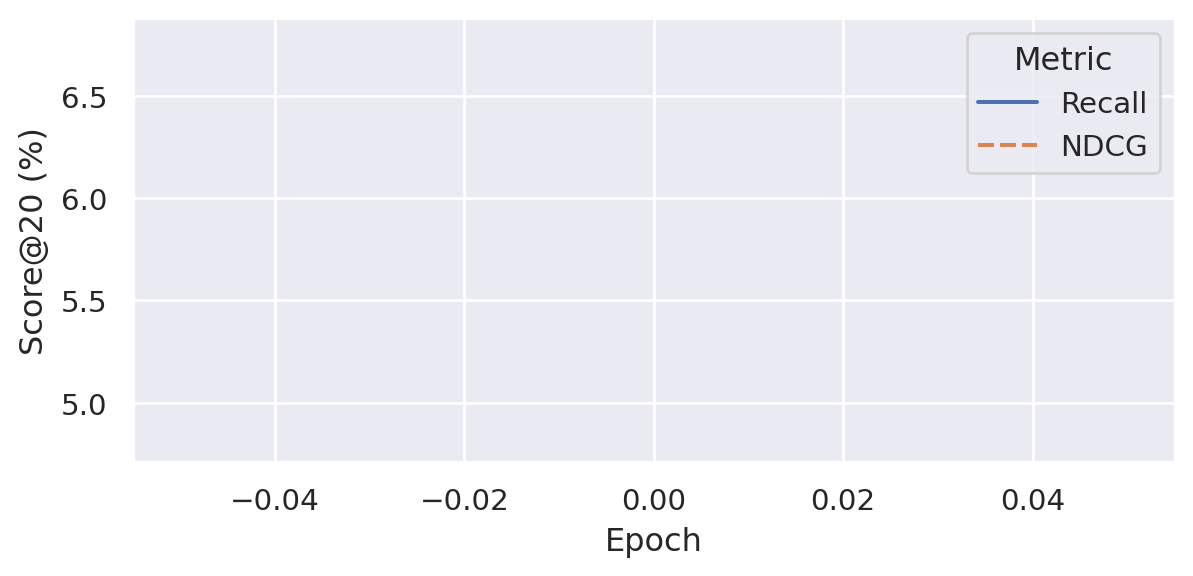

In [8]:
# Constucts the output path.
if MODEL == 'LightGCN':
    model_dir = 'light_gcn'
else:
    model_dir = 'mf'
out_path = PATH.format(
    strategy=STRATEGY,
    model=model_dir, 
    reg_factor=REG_FACTOR
)

# Potentially initiates the training session.
if TRAIN:
    utils.dispatch_session(
        module=module,
        update_fn=update_fn,
        validate_fn=validate_fn,
        verbose=True,
        num_epochs=32,
        path=out_path
    )

# Evaluation

In [ ]:
# Loads the training (and validation) loss traces.
path = os.path.join(out_path, 'trc.pkl')
with open(path, 'rb') as file:
    trace = pickle.load(file)
# Defaulting to the last epoch.
epoch_id = len(trace['update'])
# Possibly infering the epoch with smallest validation loss.
if STRATEGY == 'binary':
    _, epoch_id = min([
        (value, index)
            for index, value
            in enumerate(trace['validate'], 
                start=1
            )
    ])
# Loads that epoch's parameters.
path = os.path.join(out_path, f'mdl/{epoch_id:02d}.pt')
state_dict = torch.load(path)
# Assigns those parameters to the model.
module.load_state_dict(state_dict)

# Fetches a device.
device = utils.get_device()
# Computes the top-k recommended items of the model.
ranking = rank_fn(module, 
    device=device, 
    verbose=True
)
# Saving the top-k ranking.
path = os.path.join(out_path, 'rnk.pkl')
object = tuple(ranking)
with open(path, 'wb') as file:
    pickle.dump(object, file)

# Loading the top-k ranking.
path = os.path.join(out_path, 'rnk.pkl')
with open(path, 'rb') as file:
    _, label, total, _, _ = pickle.load(file)
# Scores the top-k ranking.
scores = utils.composite_score(label, total,
    score_fns=[
        utils.recall_score,
        utils.ndcg_score
    ]
)
# Outputs the last epoch's scores.
print('Score({})'.format(', '.join([
    '{:.2%}'.format(score) for score in scores
])))

Below are the found scores for the two different models.
```
LightGCN:
    BPR(1e-3): Score(12.07%, 7.82%)
    BPR(1e-4): Score(12.70%, 7.65%)
    BPR(1e-5): Score(12.32%, 7.66%)
    BPR(1e-6): Score(12.42%, 7.65%)
    BCE(mini): Score(10.21%, 4.73%)
MF:
    BPR(1e-3): Score(11.21%, 7.68%)
    BPR(1e-4): Score(11.01%, 7.52%)
    BPR(1e-5): Score(11.68%, 7.91%)
    BPR(1e-6): Score(11.37%, 7.71%)
    BCE(mini): Score( 6.96%, 3.75%)
```

# Visualization

In [ ]:
# Setting the plotting style.
sns.set()

# Loads the data.
frames = []
for loss, model, path in [
    ['BCE', 'MF',       PATH.format(strategy='binary',  model='mf',        reg_factor=0)],
    ['BCE', 'LightGCN', PATH.format(strategy='binary',  model='light_gcn', reg_factor=0)],
    ['BPR', 'MF',       PATH.format(strategy='triplet', model='mf',        reg_factor=1e-5)],
    ['BPR', 'LightGCN', PATH.format(strategy='triplet', model='light_gcn', reg_factor=1e-4)],
]:
    path = os.path.join(path, 'trc.pkl')
    with open(path, 'rb') as file:
        trace = pickle.load(file)
    frame = DataFrame(trace) \
        .rename(columns={'update': 'Train', 'validate': 'Validation'}) \
        .rename_axis(index='epoch', columns='dataset') \
        .stack() \
        .rename('loss') \
        .reset_index() \
        .assign(objective=loss, model=model)
    frames.append(frame)
frame = pd.concat(frames, ignore_index=True)

# Specifing which training configuration to be plotted.
model, objective = 'LightGCN', 'BCE'
# Plots the figure.
data = frame.query(f'model == "{model}" & objective == "{objective}"')
if model == 'MF' and objective == 'BCE':
    figsize = [3.25, 3]
else:
    figsize = [3.25 * .965, 3]
fig, ax = plt.subplots(
    figsize=figsize, 
    dpi=256,
    tight_layout=True
)
ax = sns.lineplot(
    data=data, 
    x='epoch',
    y='loss',
    hue='dataset',
    style='dataset',
    ax=ax
)
ax.set_xlabel('Epoch')
if model == 'MF' and objective == 'BCE':
    ax.set_ylabel('Loss')
else:
    ax.set_ylabel(None)
if model == 'LightGCN' and objective == 'BPR':
    ax.legend(title='Dataset')
else:
    ax.get_legend().remove()
plt.savefig(
    fname=f'out/figures/{objective}-{model}.png',
    bbox_inches='tight',
    pad_inches=0
)
plt.show(fig)